In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
working_dir = 'C:/Users/palmiteradmin/Documents/GitHub/MPNeuro/Ethovision/'
NUM_MICE = 6
import MPNeuro.plotting as MP_plot
import scipy
import pdb

In [35]:
import matplotlib as mpl
%matplotlib inline
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=3)

In [36]:
def load_rtpp_csv(csv_name):
    col_names = ['a', 'b', 'time', 'freq', 'hungry', 'mouse_id', 'distance', 'stim_time', 'other_time', 'middle_time', 'c']
    df = pd.read_csv(working_dir + csv_name, delimiter=';', encoding='utf-16', skiprows=3)
    df.columns = col_names
    df.drop(['a', 'b', 'c'], axis=1, inplace=True)
    return df

In [37]:
bin_min = 10 # ten minute bins
five_sated_df = load_rtpp_csv('160302 - RTPP - 5Hz sated.csv')
five_sated_df2 = load_rtpp_csv('160310 - RTPP - 5Hz sated.csv')
five_hungry_df = load_rtpp_csv('160304 - RTPP - 5Hz hungry.csv')
five_hungry_df2 = load_rtpp_csv('160315 - RTPP - 5Hz hungry.csv')
forty_sated_df = load_rtpp_csv('160307 - RTPP - 40Hz sated.csv')
forty_sated_df2 = load_rtpp_csv('160314 - RTPP - 40Hz sated.csv')
forty_hungry_df = load_rtpp_csv('160309 - RTPP - 40Hz hungry.csv')
forty_hungry_df2 = load_rtpp_csv('160322 - RTPP - 40Hz hungry.csv')

In [38]:
# combine a rtpp experiment that did not have pre-rtpp time, with one that did
def combine_dif_rtpp(no_pre_df, with_pre_df):
    no_pre_df['time'] = no_pre_df.groupby('mouse_id')['time'].shift(-1)
    no_pre_df.dropna(inplace=True)
    return no_pre_df.append(with_pre_df)
five_sated_combined_df = combine_dif_rtpp(five_sated_df, five_sated_df2)
five_hungry_combined_df = combine_dif_rtpp(five_hungry_df, five_hungry_df2)
forty_sated_combined_df = combine_dif_rtpp(forty_sated_df, forty_sated_df2)
forty_hungry_combined_df = forty_hungry_df.append( forty_hungry_df2 )

In [61]:
zero_df = pd.concat([five_sated_df2.query('time == "Start-0:10:00"'), five_hungry_df2.query('time == "Start-0:10:00"'),
          forty_sated_df2.query('time == "Start-0:10:00"')] )

In [62]:
def calc_mean_ste(df, col = 'time'):
    mean = df.groupby(col).mean() / 60 / bin_min
    ste = df.groupby(col).std() / 60 / bin_min / np.sqrt(NUM_MICE)
    return [mean.reindex(['Start-0:10:00', '0:10:00-0:20:00', '0:20:00-0:30:00']),
            ste.reindex(['Start-0:10:00', '0:10:00-0:20:00', '0:20:00-0:30:00'])]
[five_sated_mean, five_sated_ste] = calc_mean_ste(five_sated_combined_df)
[five_hungry_mean, five_hungry_ste] = calc_mean_ste(five_hungry_combined_df)
[forty_sated_mean, forty_sated_ste] = calc_mean_ste(forty_sated_combined_df)
[forty_sated_mean2, forty_sated_ste2] = calc_mean_ste(forty_sated_df2)
[forty_hungry_mean, forty_hungry_ste] = calc_mean_ste(forty_hungry_df)

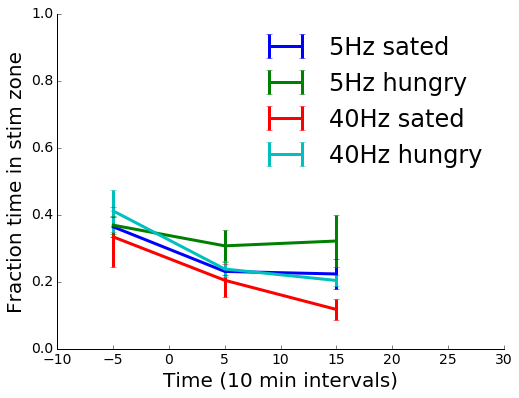

In [40]:
fig,ax = plt.subplots(1,1, figsize=[8,6])
x_indices = range(-5, 25, 10)
plt.errorbar(x_indices, five_sated_mean['stim_time'].values, five_sated_ste['stim_time'].values, label = '5Hz sated')
plt.errorbar(x_indices, five_hungry_mean['stim_time'].values, five_hungry_ste['stim_time'].values, label = '5Hz hungry')
plt.errorbar(x_indices, forty_sated_mean['stim_time'].values, forty_sated_ste['stim_time'].values, label = '40Hz sated')
plt.errorbar(x_indices, forty_hungry_mean['stim_time'].values, forty_hungry_ste['stim_time'].values, label = '40Hz hungry')
plt.ylim([0, 1])
plt.xlim([-10, 30])
plt.xlabel('Time (10 min intervals)')
plt.ylabel('Fraction time in stim zone')
plt.legend(frameon=False)
MP_plot.prettify_axes(ax)

## ANOVA

In [41]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [42]:
final_data = pd.concat([five_sated_combined_df.query('time == "0:20:00-0:30:00"'),
           five_hungry_combined_df.query('time == "0:20:00-0:30:00"'),
           forty_sated_combined_df.query('time == "0:20:00-0:30:00"'),
           forty_hungry_combined_df.query('time == "0:20:00-0:30:00"')])
final_data.sort_values(['mouse_id', 'time', 'freq', 'hungry'],inplace=True)

In [43]:
#kludge until I get MP135 for a last timepoint
temp = final_data.query('freq == 5 and hungry == "Sated" and mouse_id == "MP135"')
temp['freq'] = 40
final_data = final_data.append(temp)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [44]:
final_data.head(3)

,time,freq,hungry,mouse_id,distance,stim_time,other_time,middle_time
1,0:20:00-0:30:00,5,Hungry,MP132,2379.61,167.9340,229.200,191.266
1,0:20:00-0:30:00,5,Sated,MP132,2940.47,48.9333,393.134,151.800
2,0:20:00-0:30:00,40,Hungry,MP132,2842.68,142.2670,301.065,151.402


In [45]:
test = ols('stim_time ~ freq * hungry', data = final_data).fit()
anova_lm(test)

,df,sum_sq,mean_sq,F,PR(>F)
hungry,1,13543.482155,13543.482155,2.714418,0.114328
freq,1,29949.234406,29949.234406,6.002499,0.023140
freq:hungry,1,2618.681179,2618.681179,0.524842,0.476778
Residual,21,104778.684996,4989.461190,NaN,NaN


In [46]:
means = final_data.groupby(['hungry', 'freq'])['stim_time'].mean().values
stes = final_data.groupby(['hungry', 'freq'])['stim_time'].std().values / np.sqrt(NUM_MICE)

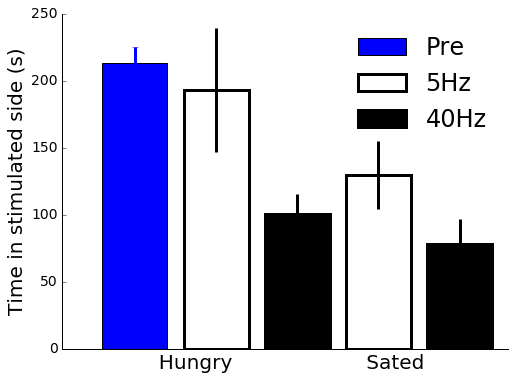

In [68]:
fig, ax = plt.subplots(figsize = [8, 6])
Hz0 = -1
Hz5 = [0,2]
Hz40 = [1,3]
plt.bar(Hz0, zero_df['stim_time'].mean(), yerr = zero_df['stim_time'].std() / NUM_MICE, label = 'Pre')
plt.bar( Hz5, means[Hz5],  color = 'w', linewidth = 3, yerr=stes[Hz5], ecolor = 'k', capsize = 0, label = '5Hz' )
plt.bar( Hz40, means[Hz40],  color = 'k', linewidth = 3, yerr=stes[Hz40], ecolor = 'k', capsize = 0, label = '40Hz'  )
plt.xlim([-1.5, 4])
MP_plot.prettify_axes(ax)
plt.legend(frameon=False)
plt.ylabel('Time in stimulated side (s)')
plt.xlabel('  Hungry                     Sated')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

In [48]:
from scipy import stats

In [49]:
stats.ttest_rel(final_data.query('freq == 5 and hungry == "Sated"')['stim_time'],
                final_data.query('freq == 40 and hungry == "Sated"')['stim_time'])

Ttest_relResult(statistic=1.5947360083306903, pvalue=0.16188177529132924)